# Загрузка библиотек

In [26]:
import random
import time
import datetime

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer,AutoTokenizer, AutoModelForMaskedLM,AutoModelForSequenceClassification
from transformers import DebertaTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, DebertaForSequenceClassification

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [3]:
data = pd.read_csv("/kaggle/input/vk-data-spam/train_spam.csv")
data

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [4]:
data["text_type"] = data["text_type"].replace("spam", 0)
data["text_type"] = data["text_type"].replace("ham", 1)

/tmp/ipykernel_34/193556689.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["text_type"] = data["text_type"].replace("ham", 1)


In [5]:
sentences = data.text.values
labels = data.text_type.values

# Загрузка текенезатора и модели

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
max_len = 0

for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (965 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  965


In [9]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 118,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  make sure alex knows his birthday is over in fifteen minutes as far as youre concerned
Token IDs: tensor([ 101, 2191, 2469, 4074, 4282, 2010, 5798, 2003, 2058, 1999, 5417, 2781,
        2004, 2521, 2004, 2115, 2063, 4986,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


In [10]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,836 training samples
2,442 validation samples


In [11]:
batch_size = 16


train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [12]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = False, 
)


# model = AutoModelForSequenceClassification.from_pretrained(
#     "distilroberta-base", 
#     num_labels = 11,    
#     output_attentions = False,
#     output_hidden_states = False,
# )

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Обучение модели

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [28]:
epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [29]:
def roc_auc(preds, labels):
    preds_prob = torch.softmax(preds, dim=1)[:, 1].detach().cpu().numpy()
    labels_flat = labels.flatten()
    return roc_auc_score(labels_flat, preds_prob)

In [30]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        res = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    
    total_eval_roc_auc = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            res = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        total_eval_loss += loss.item()

#         logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_roc_auc += roc_auc(logits, label_ids)

    avg_val_roc_auc = total_eval_roc_auc / len(validation_dataloader)
    print("  ROC_AUC: {0:.5f}".format(avg_val_roc_auc))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.5f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. ROC_AUC.': avg_val_roc_auc,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    865.    Elapsed: 0:00:07.
  Batch    80  of    865.    Elapsed: 0:00:15.
  Batch   120  of    865.    Elapsed: 0:00:22.
  Batch   160  of    865.    Elapsed: 0:00:30.
  Batch   200  of    865.    Elapsed: 0:00:37.
  Batch   240  of    865.    Elapsed: 0:00:44.
  Batch   280  of    865.    Elapsed: 0:00:52.
  Batch   320  of    865.    Elapsed: 0:00:59.
  Batch   360  of    865.    Elapsed: 0:01:07.
  Batch   400  of    865.    Elapsed: 0:01:14.
  Batch   440  of    865.    Elapsed: 0:01:21.
  Batch   480  of    865.    Elapsed: 0:01:29.
  Batch   520  of    865.    Elapsed: 0:01:36.
  Batch   560  of    865.    Elapsed: 0:01:44.
  Batch   600  of    865.    Elapsed: 0:01:51.
  Batch   640  of    865.    Elapsed: 0:01:58.
  Batch   680  of    865.    Elapsed: 0:02:06.
  Batch   720  of    865.    Elapsed: 0:02:13.
  Batch   760  of    865.    Elapsed: 0:02:21.
  Batch   800  of    865.    Elapsed: 0:02:28.
  Batch   840  o

In [32]:
pd.options.display.precision
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. ROC_AUC.,Training Time,Validation Time
epoch,,,,,
1,0.024432,0.204326,0.990533,0:02:40,0:00:09
2,0.048309,0.132058,0.993208,0:02:40,0:00:09
3,0.017754,0.212117,0.991687,0:02:40,0:00:09
4,0.006491,0.207396,0.990928,0:02:40,0:00:09
5,0.004522,0.202362,0.991690,0:02:40,0:00:09
6,0.003135,0.232130,0.990865,0:02:40,0:00:09
7,0.002882,0.220704,0.990525,0:02:40,0:00:09
8,0.003325,0.251161,0.991472,0:02:40,0:00:09
9,0.001940,0.190597,0.991877,0:02:40,0:00:09


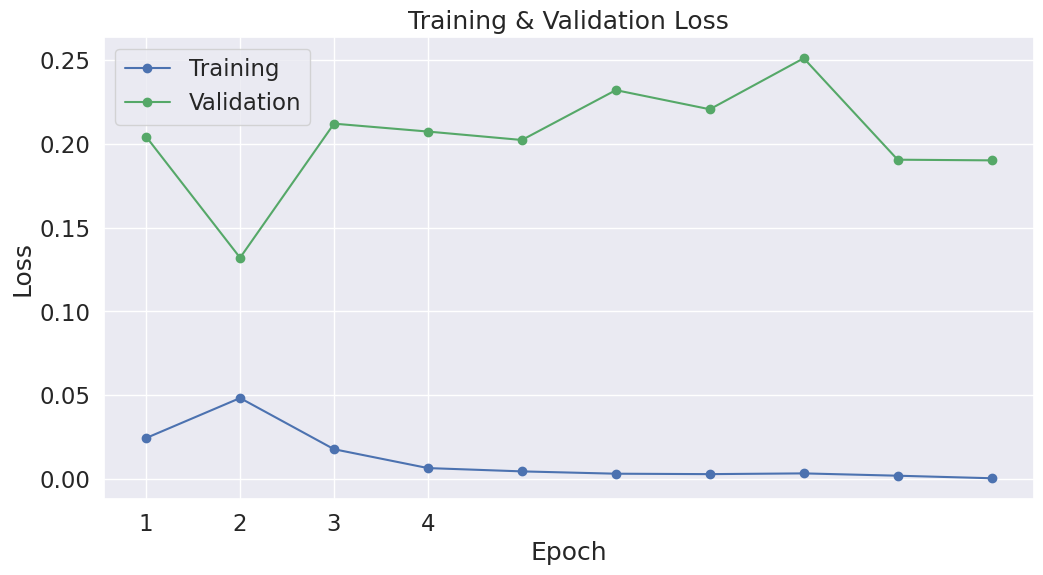

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [34]:
test = pd.read_csv("/kaggle/input/vk-data-spam/test_spam.csv")
test

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [36]:
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

sentences = test.text.values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 118,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
       
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
  
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,070



/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()
 
predictions , true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    #   label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
print('    DONE.')

Predicting labels for 4,070 test sentences...
    DONE.


In [38]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [39]:
test["groups"] = flat_predictions
test = test.drop("text", axis=1)
test

,groups
0,1
1,1
2,1
3,1
4,0
...,...
4065,1
4066,1
4067,1
4068,1
